## EDSA Movie Recommendation 2022
### Team CW2
© Explore Data Science Academy

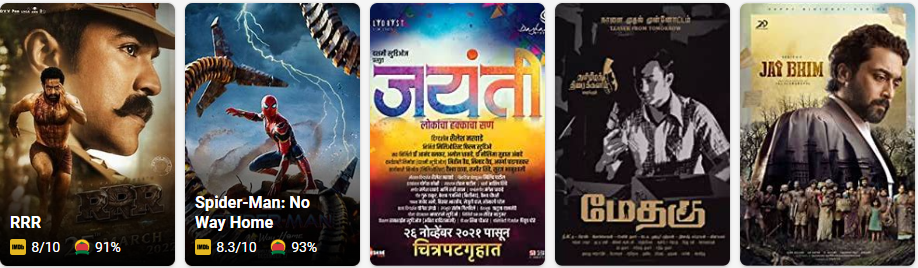

<a id="cont"></a>
## Table of Contents
<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploring Data</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

<a href=#eight>8. References</a>

<a id="three"></a>
## 1. Importing Packages
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [98]:
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

<a id="three"></a>
## 2. Loading Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [116]:
#Loading data tables
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
genome_scores_data = pd.read_csv('genome_scores.csv')
genome_tags_data = pd.read_csv('genome_tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
links_data = pd.read_csv('links.csv')
movies_data = pd.read_csv('movies.csv')
sample_submission = pd.read_csv('sample_submission.csv')
tags_data = pd.read_csv('tags.csv')

<a id="three"></a>
## 3. Exploring Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [119]:
#Looking at the shape of data of each table
shape = {
    'Genome Scores': genome_scores_data.shape,'Genome Tags': genome_tags_data.shape,'IMDB': imdb_data.shape,'Links': links_data.shape,
    'Movies': movies_data.shape,'Tags': tags_data.shape,'Train': train_data.shape,'Test': test_data.shape
    }
#store the results inside a pandas data frame
df_shape = pd.DataFrame(list(shape.items()), columns=['Data Table', 'Shape'])
df_shape

,Data Table,Shape
0,Genome Scores,"(15584448, 3)"
1,Genome Tags,"(1128, 2)"
2,IMDB,"(27278, 6)"
3,Links,"(62423, 3)"
4,Movies,"(62423, 3)"
5,Tags,"(1093360, 4)"
6,Train,"(10000038, 4)"
7,Test,"(5000019, 2)"


In [121]:
# Display the data tables
print('-------------------------------------------------------------------------------------------------------------------------------')
print('Movies')
display(movies_data.sample(5))
print('-------------------------------------------------------------------------------------------------------------------------------')
print('imdb')
display(imdb_data.sample(5))
print('-------------------------------------------------------------------------------------------------------------------------------')
print('Tags')
display(tags_data.sample(5))
print('-------------------------------------------------------------------------------------------------------------------------------')
print('Genome scores')
display(genome_scores_data.sample(5))
print('-------------------------------------------------------------------------------------------------------------------------------')
print('Genome tags')
display(genome_tags_data.sample(5))
print('-------------------------------------------------------------------------------------------------------------------------------')
print('Links')
display(links_data.sample(5))

-------------------------------------------------------------------------------------------------------------------------------
Movies


,movieId,title,genres
803,821,"Crude Oasis, The (1995)",Drama|Romance
23462,118175,13 West Street (1962),Crime|Drama
42185,163312,Dhamaal (2007),Comedy
37807,153426,Risto Räppääjä ja Sevillan saituri (2015),Children
4946,5052,Time of Favor (Ha-Hesder) (2000),Drama|War


-------------------------------------------------------------------------------------------------------------------------------
imdb


,movieId,title_cast,director,runtime,budget,plot_keywords
23123,110240,Natassia Malthe|Zack Ward|Michael Paré|Chris C...,Christopher Donaldson,99.0,"$10,000,000",19th century|returning character with differen...
1364,1395,NaN,NaN,NaN,NaN,NaN
11000,45188,Kang-sheng Lee|Shiang-chyi Chen|Yi-Ching Lu|Ku...,Ming-liang Tsai,NaN,NaN,adult actress appearing in mainstream film|exp...
21540,104459,NaN,NaN,NaN,NaN,NaN
1339,1370,NaN,NaN,NaN,NaN,NaN


-------------------------------------------------------------------------------------------------------------------------------
Tags


,userId,movieId,tag,timestamp
28690,5801,6857,anime,1519790530
25751,5196,53127,suspenseful,1454266861
972395,141361,40597,drama,1333729745
943221,137149,96737,violent,1369078910
1012501,149116,1193,classic,1250718297


-------------------------------------------------------------------------------------------------------------------------------
Genome scores


,movieId,tagId,relevance
9014749,32840,902,0.03950
5164245,5075,262,0.02525
6036788,6011,861,0.02450
8694799,27758,176,0.04325
11617022,78836,879,0.02100


-------------------------------------------------------------------------------------------------------------------------------
Genome tags


,tagId,tag
323,324,dramatic
541,542,indiana jones
283,284,dancing
924,925,slackers
815,816,product placement


-------------------------------------------------------------------------------------------------------------------------------
Links


,movieId,imdbId,tmdbId
40027,158518,5275886,379500.0
51360,182975,1538819,35963.0
13732,71147,48394,72083.0
60625,203743,10514532,612295.0
25179,123155,93898,27738.0


In [128]:
# How many unique entries for movies, users, actors?
unique_movies = len(movies_data['movieId'].unique().tolist())
unique_users = len(train_data['userId'].unique().tolist())
unique_actors = len(imdb_data['title_cast'].unique().tolist())

unique_characters = pd.DataFrame({"Users": [unique_users],
                                  "Movies": [unique_movies],
                                  "Actors" : [unique_actors],
                                 }, index=['No. of unique entries'])

display(unique_characters.transpose())

,No. of unique entries
Users,162541
Movies,62423
Actors,17144


In [138]:
train_data.rating.value_counts()

4.0    2652977
3.0    1959759
5.0    1445230
3.5    1270642
4.5     880516
2.0     656821
2.5     505578
1.0     311213
1.5     159731
0.5     157571
Name: rating, dtype: int64

In [150]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies_data[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,"Adventure , Animation , Children , Comedy , Fa..."
1,2,"Adventure , Children , Fantasy"
2,3,"Comedy , Romance"
3,4,"Comedy , Drama , Romance"
4,5,Comedy


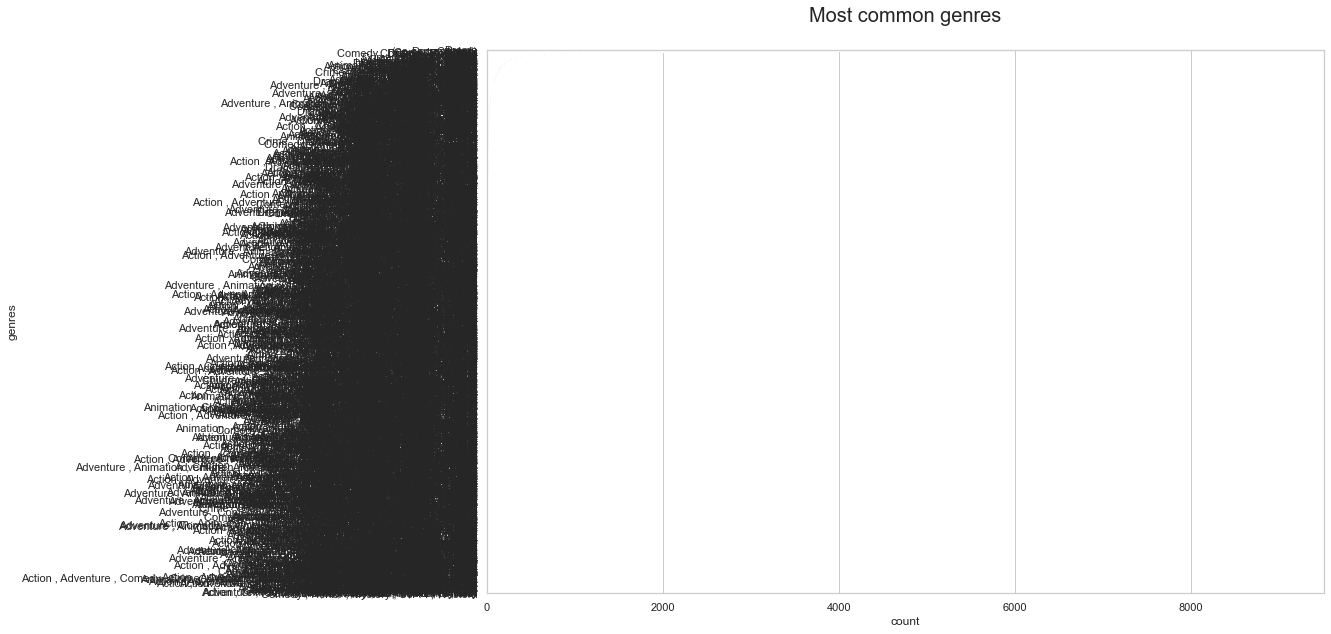

In [151]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

In [152]:
# Number of ratings per movie
data = train_data.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Movie',
                   xaxis = dict(title = 'Number of Ratings Per movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [153]:
train_data.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userId,rating
72314,72315,12952
80973,80974,3680
137292,137293,3588
33843,33844,3208
20054,20055,3050
109730,109731,2671
49402,49403,2670
92045,92046,2579
110970,110971,2288
30878,30879,2284


In [104]:
test_data = pd.read_csv("test.csv")
test_data

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318
...,...,...
5000014,162541,4079
5000015,162541,4467
5000016,162541,4980
5000017,162541,5689


In [105]:
test_data.shape[0]

5000019

In [106]:
movie_data = pd.read_csv("movies.csv")
movie_data

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [107]:
X = pd.merge(train_data,movie_data, on = "movieId")
X

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller
...,...,...,...,...,...,...
10000033,84146,107912,3.0,1389449965,"Fallen, The (2004)",Action|Drama|War
10000034,72315,190143,2.5,1567628158,Formentera Lady,(no genres listed)
10000035,131116,206347,3.0,1568558126,Nocturne (1946),Crime|Drama|Mystery
10000036,85757,196867,3.5,1563175258,Guys & Balls (2004),Comedy|Romance


In [108]:
X = pd.merge(train_data,movie_data, on = "movieId")
X

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller
...,...,...,...,...,...,...
10000033,84146,107912,3.0,1389449965,"Fallen, The (2004)",Action|Drama|War
10000034,72315,190143,2.5,1567628158,Formentera Lady,(no genres listed)
10000035,131116,206347,3.0,1568558126,Nocturne (1946),Crime|Drama|Mystery
10000036,85757,196867,3.5,1563175258,Guys & Balls (2004),Comedy|Romance


In [109]:
X = pd.merge(data,X, on = "movieId")
X

,movieId,title_cast,director,runtime,budget,plot_keywords,userId,rating,timestamp,title,genres
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,158849,5.0,994716786,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,97203,5.0,942683155,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,161871,3.0,833104576,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,45117,4.0,1442256969,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,27431,5.0,849667827,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...,...,...,...,...,...
9633026,131262,Sophie Lane Curtis|Kelly Reilly|Graham Phillip...,Hilary Brougher,96.0,NaN,hex|witch|virgin|blood,33844,2.5,1436135246,Innocence (2014),Adventure|Fantasy|Horror
9633027,131262,Sophie Lane Curtis|Kelly Reilly|Graham Phillip...,Hilary Brougher,96.0,NaN,hex|witch|virgin|blood,51278,3.0,1434134840,Innocence (2014),Adventure|Fantasy|Horror
9633028,131262,Sophie Lane Curtis|Kelly Reilly|Graham Phillip...,Hilary Brougher,96.0,NaN,hex|witch|virgin|blood,73268,1.0,1475289253,Innocence (2014),Adventure|Fantasy|Horror
9633029,131262,Sophie Lane Curtis|Kelly Reilly|Graham Phillip...,Hilary Brougher,96.0,NaN,hex|witch|virgin|blood,7865,1.0,1456452588,Innocence (2014),Adventure|Fantasy|Horror


In [113]:
X['content'] = (pd.Series(X[['title_cast', 'director', 'rating', 'title']]
                      .fillna('')
                      .values.tolist()).str.join(' '))

In [111]:
# Convienient indexes to map between book titles and indexes of 
# the books dataframe
titles = X['title']
indices = pd.Series(X.index, index=X['title'])

In [69]:
print (f'Number of ratings in dataset: {X.shape[0]}')

Number of ratings in dataset: 10000038


Text(0.5, 0, 'Rating')

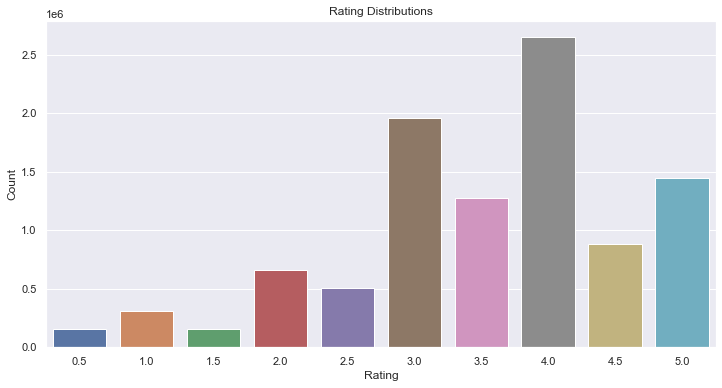

In [140]:
plt.figure (figsize= (12,6))
distribution = pd.DataFrame(list(train_data['rating'].value_counts()),
                                   index=[4, 3, 5, 3.5, 4.5, 2, 2.5, 1, 1.5, 0.5],
                                   columns=['Count'])
sns.set()
sns.color_palette("crest", as_cmap=True)
sns.barplot(x=distribution.index, y=distribution.Count)
plt.title('Rating Distributions')
plt.xlabel('Rating')

In [141]:
# Determine and display the min and max ratings received
min_rating = train_data.rating.min()
max_rating = train_data.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

Lowest rating: 0.5
Highest rating: 5.0


In [145]:
movies_data["genres"] = movies_data["genres"].str.replace('|', ',', regex=True)
movies_data['year'] = movies_data['title'].str.extract(r"\((\d+)\)", expand=False)
movies_data.sample(3)

,movieId,title,genres,year
17698,92408,Batch '81 (1982),Drama,1982
58378,198475,Treasures from the Wreck of the Unbelievable (...,Documentary,2017
12765,63181,Tokyo Gore Police (Tôkyô zankoku keisatsu) (2008),"Action , Horror",2008


In [146]:
movies_data.year.info()

<class 'pandas.core.series.Series'>
RangeIndex: 62423 entries, 0 to 62422
Series name: year
Non-Null Count  Dtype 
--------------  ----- 
62013 non-null  object
dtypes: object(1)
memory usage: 487.8+ KB


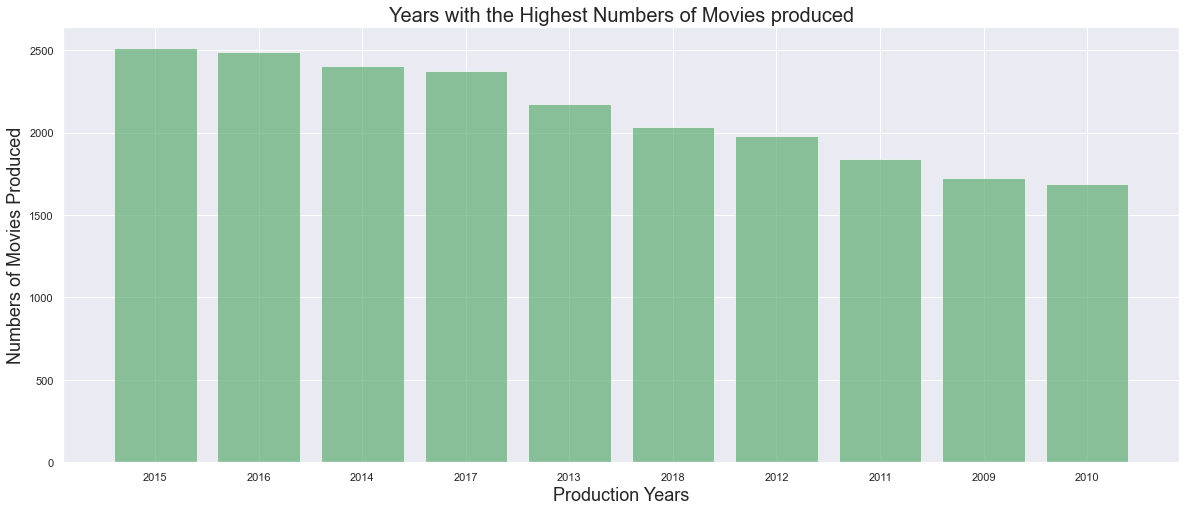

In [148]:
movies_year_count = movies_data["year"].value_counts()
fig, ax = plt.subplots( figsize=(20,8))

ax.bar(movies_year_count.index[:10], movies_year_count.values[:10],  facecolor='g', alpha=0.65)
ax.set_xlabel("Production Years", fontsize = 18)
ax.set_ylabel("Numbers of Movies Produced", fontsize = 18)
ax.set_title("Years with the Highest Numbers of Movies produced", fontsize = 20)
plt.show()

Text(0, 0.5, 'Number of Ratings')

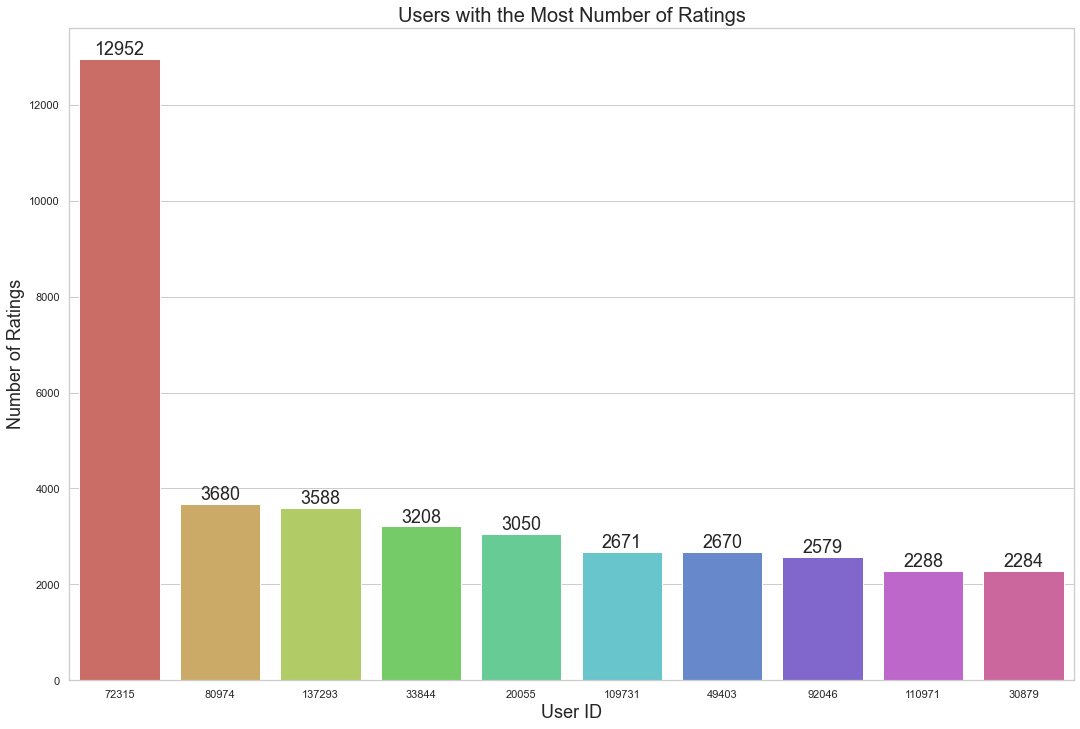

In [149]:
plt.figure(figsize=(18,12))
sns.set_style("whitegrid") 
data = train_data['userId'].value_counts(ascending=False).head(10)
fig = sns.barplot(x=data.index, y=data, order=data.index, palette='hls')
for i in fig.patches:
        fig.text(i.get_x() + i.get_width()/2, i.get_height(), '%d' % int(i.get_height()), fontsize=18, ha='center', va='bottom')
plt.title("Users with the Most Number of Ratings", size=20)
plt.xlabel("User ID", size=18)
plt.ylabel("Number of Ratings", size=18)

<a id="four"></a>
## 6. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [72]:
X.isna().sum().sum()

0

In [73]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000038 entries, 0 to 10000037
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 534.1+ MB


In [74]:
X.rating.value_counts()

4.0    2652977
3.0    1959759
5.0    1445230
3.5    1270642
4.5     880516
2.0     656821
2.5     505578
1.0     311213
1.5     159731
0.5     157571
Name: rating, dtype: int64

In [92]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0, stop_words='english')
 
tf_content = tf.fit_transform(X)

In [93]:
tf_X

<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [94]:
cosine_sim_X = cosine_similarity(tf_X,
                                        tf_X)
print (cosine_sim_X.shape)

(6, 6)


In [95]:
cosine_sim_X[:5]

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [38]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movie_data[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


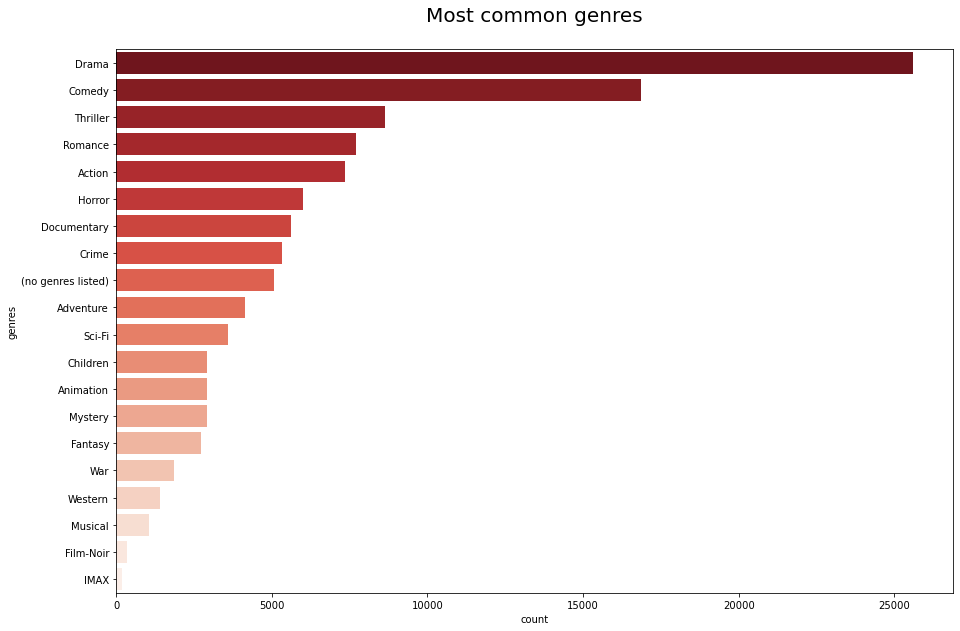

In [39]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

In [44]:
# Number of ratings per movie
data = train_data.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Movie',
                   xaxis = dict(title = 'Number of Ratings Per movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [46]:
train_data.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userId,rating
72314,72315,12952
80973,80974,3680
137292,137293,3588
33843,33844,3208
20054,20055,3050
109730,109731,2671
49402,49403,2670
92045,92046,2579
110970,110971,2288
30878,30879,2284


In [90]:
def content_generate_top_N_recommendations(title, N):
    # Convert the string book title to a numeric index for our 
    # similarity matrix
    m_idx = indices[title]
    # Extract all similarity values computed with the reference book title
    sim_scores = list(enumerate(cosine_sim_cast_director[m_idx]))
    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N]
    # Collect indexes 
    movie_indices = [i[0] for i in sim_scores]
    # Convert the indexes back into titles 
    return titles.iloc[movie_indices]

In [91]:
content_generate_top_N_recommendations("Toy Story", N=10)

KeyError: 'Toy Story'